In [11]:
# 4) get_teensy_data() + plotting
import serial
import struct
import time
import os

import numpy as np
import matplotlib.pyplot as plt

# ---- CONFIG ----
PORT        = 'COM9'
BAUDRATE    = 115200
TIMEOUT     = 5

V_REF       = 3.3
ADC_MAX     = 1023.0
R_REF       = 1000.0

S_HIGH      = 1000
S_LOW       = 16000
BYTES_H     = S_HIGH * 2
BYTES_TH    = 4
BYTES_L     = S_LOW  * 2
BYTES_TL    = 4
BYTES_AG    = 4               # float32
TOTAL_BYTES = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL + BYTES_AG

RAW_DIR = r'C:\Users\klipk\Downloads\teensy_raw'
os.makedirs(RAW_DIR, exist_ok=True)

def pt1000_lookup(R):
    T_ref = np.array([-79, -70, -60, -50, -40, -30,
                      -20, -10,   0,  10,  20,  30])
    R_ref = np.array([687.30, 723.30, 763.30, 803.10,
                      842.70, 882.20, 921.60, 960.90,
                      1000.00,1039.00,1077.90,1116.70])
    return np.interp(R, R_ref, T_ref)

def get_teensy_data():
    with serial.Serial(PORT, BAUDRATE, timeout=TIMEOUT) as ser:
        ser.setDTR(True)
        time.sleep(2.0)
        ser.reset_input_buffer()

        ser.write(b'S')
        time.sleep(0.05)
        raw = ser.read(TOTAL_BYTES)
        if len(raw) != TOTAL_BYTES:
            raise RuntimeError(f"Expected {TOTAL_BYTES} bytes, got {len(raw)}")

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    fname     = os.path.join(RAW_DIR, f"teensy_raw_{timestamp}.bin")
    with open(fname, 'wb') as f:
        f.write(raw)
    print(f"[OK] Raw data saved to {fname}")

    idx       = 0
    vh        = np.frombuffer(raw[idx:idx+BYTES_H],   dtype=np.uint16); idx += BYTES_H
    t_high    = struct.unpack('<I',  raw[idx:idx+BYTES_TH])[0];       idx += BYTES_TH
    vl        = np.frombuffer(raw[idx:idx+BYTES_L],   dtype=np.uint16); idx += BYTES_L
    t_low     = struct.unpack('<I',  raw[idx:idx+BYTES_TL])[0];       idx += BYTES_TL
    avg_count = struct.unpack('<f',  raw[idx:idx+BYTES_AG])[0]        # float32

    return vh, t_high, vl, t_low, avg_count

if __name__ == "__main__":
    vh, t_high, vl, t_low, avg_count = get_teensy_data()

    dt_h = t_high / S_HIGH
    dt_l = (t_low - t_high)  / S_LOW
    t_h  = np.arange(S_HIGH) * dt_h + dt_h
    t_l  = t_h[-1] + dt_h + np.arange(S_LOW) * dt_l + dt_l

    v_h  = vh * (V_REF / ADC_MAX)
    v_l  = vl * (V_REF / 4095.0)

    V_th = avg_count / ADC_MAX * V_REF
    R_th = R_REF * V_th / (V_REF - V_th)
    T_C = pt1000_lookup(R_th)
    v_offset = v_l[-1]
    
    normal = v_h[0]
    #v_l = v_l - v_offset
    #v_h = v_h - v_offset

    v_h = v_h / (normal)
    v_l = v_l / (normal)

    V_th = avg_count / ADC_MAX * V_REF
    R_th = R_REF * V_th / (V_REF - V_th)
    T_C = pt1000_lookup(R_th)
    ## 

   

[OK] Raw data saved to C:\Users\klipk\Downloads\teensy_raw\teensy_raw_20250729_155647.bin


Capacitance = 100.30333096550491 
High-speed: 1.00 µs/sample
Low-speed : 157.58 µs/sample
Temperature: 24.4 °C
0.19192261306532662
0.09695702643252894
0.3150915750915751


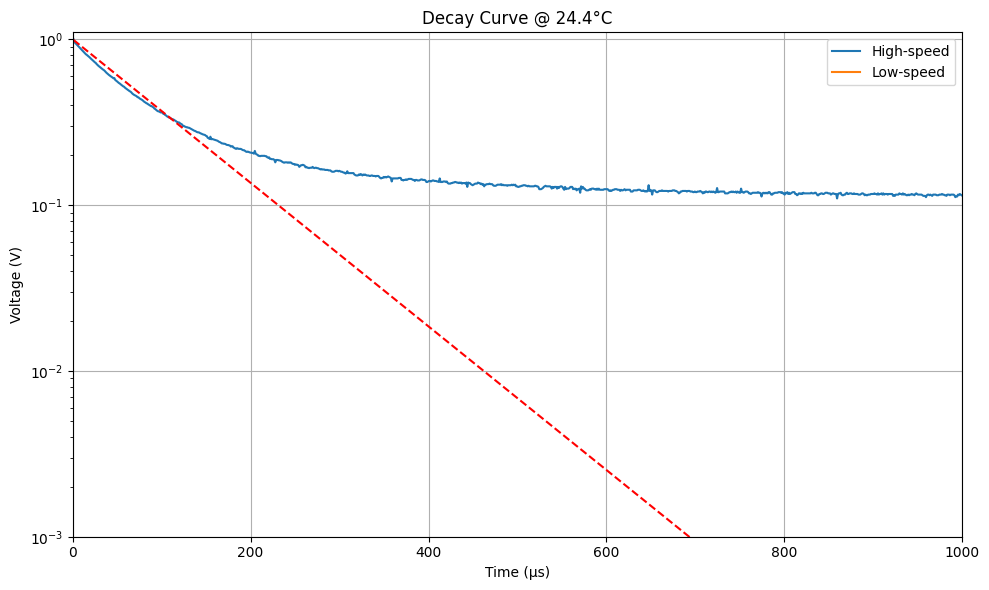

In [12]:
def calculate_capacitance(t_us, v, R_ohm):
            t = t_us * 1e-6   # now in seconds

    # limit fit to the “clean” exponential region:
    # here I pick v > 5% of V0 to avoid floor/noise
            v0 = v[0]
            mask = (v > 0.05*v0) & (v < v0)
            t_fit = t[mask]
            v_fit = v[mask]

    # linearize: ln(V/V0) = -t/(R C)
            ln_ratio = np.log(v_fit / v0)

    # slope = d/dt [ln(V/V0)] = -1/(R C)
            slope, intercept = np.polyfit(t_fit, ln_ratio, 1)
            tau_s = -1.0 / slope       # in seconds
            C_F   = tau_s / R_ohm     # in farads

    # return both in familiar units
            return float(C_F)     # tau back to microseconds
import numpy as np
import scipy.constants as scc

t_all = np.concatenate((t_h, t_l))
v_all = np.concatenate((v_h, v_l))
R = scc.mega
C = calculate_capacitance(t_all[:100],v_all[:100],R)
print(f'Capacitance = {C/scc.pico} ')
print(f"High-speed: {dt_h:.2f} µs/sample")
print(f"Low-speed : {dt_l:.2f} µs/sample")
print(f"Temperature: {T_C:.1f} °C")
print(np.average(v_h))
print(np.average(v_l))
print(v_offset)
plt.figure(figsize=(10,6))
plt.plot(t_h, v_h, label="High-speed")
plt.plot(t_l, v_l, label="Low-speed")
plt.plot(t_all,np.exp(-t_all*scc.micro/C/R),'--r')
plt.xlabel("Time (µs)")
plt.ylabel("Voltage (V)")
plt.title(f"Decay Curve @ {T_C:.1f}°C")
plt.xscale('linear')
plt.xlim(0,1000)
plt.yscale('log')
plt.ylim(1e-3,1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Capacitance = 54756708904543.17 


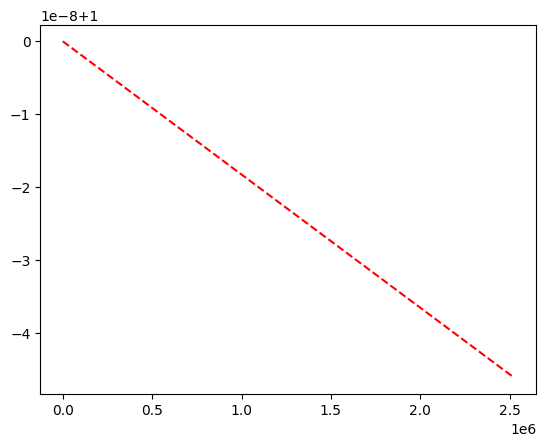